This code aims to download precipitation data for Ethiopia from CHIRPS and calculate the monthly average at 1000 m resolution for the years 2012 to 2021. An acompanying code downloads the data for 2022 and then this csv is appended to the one obtained from this code. 

1. We import the libraries and intialize GEE

In [52]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json
import ee
%matplotlib inline
import seaborn as sns
from ipygee import*
from shapely.geometry import Polygon

# Trigger the authentication flow.
# ee.Authenticate()
    
# Initialize the GEE
ee.Initialize()

2. I downloaded a shape files from [GADM maps and data](https://gadm.org/download_country.html) to get Ethiopia's shape file

(1, 3)
  GID_0   COUNTRY                                           geometry
0   ETH  Ethiopia  POLYGON ((38.43719 3.60126, 38.42982 3.60086, ...


<function matplotlib.pyplot.show(close=None, block=None)>

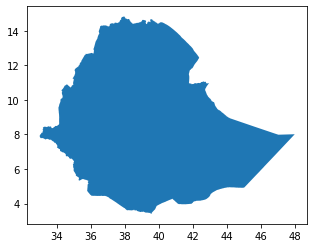

In [61]:
# Define geograpic domain
# read the shapefile of the study area
Ethiopia = gpd.read_file('/Users/valentinaguedesantonaccio/Library/CloudStorage/OneDrive-Nexus365/I.FoD/II.Research/VIII.Labour_Ethiopia/Precipitation/gadm41_ETH_shp/gadm41_ETH_0.shp')
print(Ethiopia.shape)
print(Ethiopia.head())
Ethiopia.plot() #create the plot
plt.show #show the plot

3. Convert the shape file into Java Script Object Notation (JSON)

In [62]:
# converting from shapefile to json (aoi = area of interest)
aoi = Ethiopia.to_json()
# load json file
aoi = json.loads(aoi)
# select features
aoi = aoi['features']

aoi = ee.FeatureCollection(aoi).geometry()

4. Select the years and months I want to delimit my data from.

In [63]:
startyear1 = 2012
endyear1 = 2023 #(<2022)

# Set date in ee date format
startdate1 = ee.Date.fromYMD(startyear1,1,1)
enddate1 = ee.Date.fromYMD(endyear1,12,31)

# Make a list for years
years1 = range(startyear1, endyear1);

# Make a list for months
months = range(1,13)

5. Import the Image Collection from CHIRPS selecting "precipitation" which is the variable we want, filtering by date and the bounds of the country. 

In [64]:
# import the RS products from CHIRPS
CHIRPS = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')\
                            .select('precipitation')\
                            .filterDate(startdate1,enddate1)\
                            .filterBounds(aoi)

CHIRPS.first().propertyNames().getInfo()
# print(CHIRPS.getInfo())

['system:time_start',
 'month',
 'year',
 'system:footprint',
 'system:time_end',
 'system:version',
 'system:id',
 'system:asset_size',
 'pentad',
 'system:index',
 'system:bands',
 'system:band_names']

6. Calculate the precipitation total over the months and years specified. If we do not do that we get observations for the PENTAD. 

In [65]:
#  Calculating Monthly Sum
def MonthlySum1(imageCollection1):
  mylist1 = ee.List([])
  for y in years1:
    for m in months:
      w = imageCollection1.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum()
      mylist1 = mylist1.add(w.set('year', y)\
                          .set('month', m)\
                          .set('date', ee.Date.fromYMD(y,m,1)))
  
  return ee.ImageCollection.fromImages(mylist1).set('date', ee.Date.fromYMD(y, m, 1))

# run the calcMonthlySum1 function
monthlyCHIRPS = ee.ImageCollection(MonthlySum1(CHIRPS))
monthlyCHIRPS.first().propertyNames().getInfo()

# print("All from CHIRPS")
# print(monthlyCHIRPS.getInfo())

['date', 'month', 'year', 'system:index', 'system:bands', 'system:band_names']

   6. Image Collection Reductions

What we have so far is a series of images represented by an `ImageCollection` summed by year and month. But for every combination of year and month we have an `ImageColleciton`. So, if we apply `imageCollection.reduce()` we are going to reduce a series of images into an individual one. More specifically, the optuput is computed pixel-wise, such that each pixel in the output is composed of the median value of all the images in the collection at that location. Here we use the shortcut method provided by `ImageCollection` to calculate `min()`, `max()`, `mean()`. 

In [57]:
# Statistics function

def reduce (image):
  serie_reduce = image.reduceRegions(**{
      'collection': aoi,
      'reducer': ee.Reducer.mean().combine(**{
      'reducer2': ee.Reducer.max(),
      'sharedInputs': True}).combine(**{
        'reducer2': ee.Reducer.min(),
        'sharedInputs': True}),
      'scale': 1000,
      })
  
  serie_reduce = serie_reduce.map(lambda f: f.set({'millis': image.get('millis')}))\
                             .map(lambda f: f.set({'date': image.get('date')}))\
                             .map(lambda f: f.set({'month': image.get('month')}))\
                             .map(lambda f: f.set({'year': image.get('year')}))

  return serie_reduce.copyProperties(image, ['system:time_start'])


precipitation_reduce = CHIRPS.map(reduce)\
                             .flatten()\
                             .sort('date', True)\
                             .select(['millis', 'date', 'max', 'mean', 'min', 'month', 'year'])
 
    

7. Now we get the data list:

In [58]:
# creating the data list
prec_list = precipitation_reduce.reduceColumns(ee.Reducer.toList(5), ['max', 'mean', 'min', 'month', 'year']).values().get(0)
 
print("Precipitation reduce columns:",prec_list.getInfo())

Precipitation reduce columns: [[4.924854278564453, 0.8377120670765306, 0, 1, 2012], [10.115154266357422, 0.8854003586064962, 0, 1, 2012], [11.539037704467773, 0.8954198319027338, 0, 1, 2012], [6.139046669006348, 0.8406565886726384, 0, 1, 2012], [16.261489868164062, 0.9418115537357996, 0, 1, 2012], [17.40043830871582, 1.1710468037221815, 0, 1, 2012], [3.8376917839050293, 0.8362026588904292, 0, 2, 2012], [4.598628997802734, 0.9032785685408076, 0, 2, 2012], [4.533889293670654, 0.8909621434660585, 0, 2, 2012], [14.092069625854492, 1.0946753204182589, 0, 2, 2012], [8.8130464553833, 1.0118837809122962, 0, 2, 2012], [12.545549392700195, 1.3545945398905346, 0, 2, 2012], [55.622337341308594, 4.290643146591153, 0, 3, 2012], [23.95069122314453, 2.015927465907535, 0, 3, 2012], [9.6202392578125, 1.550643147223803, 0, 3, 2012], [25.59803581237793, 2.1088350625760235, 0, 3, 2012], [77.21644592285156, 5.052612780775992, 0, 3, 2012], [78.34918975830078, 8.050276922597138, 0.03571435064077377, 3, 2012],

8. And convert the Image Collection into a Data Frame

In [66]:
# creating the dataframe

df_prec = pd.DataFrame(prec_list.getInfo(), columns=['max_prec', 'mean_prec', 'min_prec', 'month', 'year'])

df_prec

# export to .csv
prec_csv1 = df_prec.to_csv('/Users/valentinaguedesantonaccio/Library/CloudStorage/OneDrive-Nexus365/I.FoD/II.Research/VIII.Labour_Ethiopia/Precipitation/CSV/precipitation1.csv')

9. and append to the 2012-2021 data the 2022 data obtained in the other code. 

In [67]:
df_prec1 = pd.read_csv('/Users/valentinaguedesantonaccio/Library/CloudStorage/OneDrive-Nexus365/I.FoD/II.Research/VIII.Labour_Ethiopia/Precipitation/CSV/precipitation1.csv')
df_prec2 = pd.read_csv('/Users/valentinaguedesantonaccio/Library/CloudStorage/OneDrive-Nexus365/I.FoD/II.Research/VIII.Labour_Ethiopia/Precipitation/CSV/precipitation2.csv')

pd.concat([df_prec, df_prec2], ignore_index=True).drop('Unnamed: 0', axis=1).to_csv('CSV/precipitation_2012_2022.csv', index=True)

This code is based on mvnlucian's on [GitHub](https://github.com/mnvlucian/Google-Earth-Engine-CHIRPS-Statistics/blob/main/CHIRPS_Statistics.ipynb), [Google Earth Engine](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api) and this [Blog](https://bikeshbade.com.np/tutorials/Detail/?title=Chirps%20Precipitation%20to%20Excel%20-%20GEE%20and%20Pandas&code=14)